In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report 

from sklearn import metrics
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
import lightgbm as lgbm

from feature_selector import FeatureSelector
pd.options.mode.chained_assignment = None

In [2]:
url="arrhythmia.data"
#url="https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data"
#names="https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.names"
cardio=pd.read_csv(url,header=None, na_values="?")
cardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, 0 to 279
dtypes: float64(125), int64(155)
memory usage: 988.8 KB


In [3]:
base_col_names = '''Age Sex Height Weight
        QRS_duration PR_interval
        QT_interval T_interval P_interval
        QRS_angle T_angle P_angle QRST_angle J_angle
        Heart_rate
        '''.split()

sensors = '''d1 d2 d3 avr avl avf v1 v2 v3 v4 v5 v6'''.split()


w_attrs = '''Q_width R_width S_width
        R2_width S2_width Intrinsic_deflections
        Exist_ragged_R Exist_diphasic_R
        Exist_ragged_P Exist_diphasic_P
        Exist_ragged_T Exist_diphasic_T
        '''.split()


a_attrs = '''JJ_amplitude Q_amplitude R_amplitude
        S_amplitude R2_amplitude S2_amplitude
        P_amplitude T_amplitude
        QRSA QRSTA
        '''.split()



col_names = (base_col_names
                + [sensor + '_' + w_attr
                   for sensor in sensors for w_attr in w_attrs]
                + [sensor + '_' + a_attr
                   for sensor in sensors for a_attr in a_attrs]
                + ['Class'])
len(col_names)

280

In [4]:
cardio.set_axis(col_names, axis=1,inplace=True)
cardio.head()

,Age,Sex,Height,Weight,QRS_duration,PR_interval,QT_interval,T_interval,P_interval,QRS_angle,...,v6_Q_amplitude,v6_R_amplitude,v6_S_amplitude,v6_R2_amplitude,v6_S2_amplitude,v6_P_amplitude,v6_T_amplitude,v6_QRSA,v6_QRSTA,Class
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7


In [5]:
class_names = { 1: 'Normal_ECG',
                2: 'Ischemic_changes',
                3: 'Old_Anterior_Myocardial_Infarction',
                4: 'Old_Inferior_Myocardial_Infarction',
                5: 'Sinus_tachycardia',
                6: 'Sinus_bradycardia',
                7: 'Ventricular_Premature_Contraction',
                8: 'Supraventricular_Premature_Contraction',
                9: 'Left_bundle_branch_block',
                10: 'Right_bundle_branch_block',
                11: 'First_degree_AtrioVentricular_block',
                12: 'Second_degree_AtrioVentricular_block',
                13: 'Third_degree_AtrioVentricular_block',
                14: 'Left_ventricule_hypertrophy',
                15: 'Atrial_Fibrilation_or_Flutter',
                16: 'Others'
                     }

In [6]:
# map to class names
cardio['Class'].map(class_names).value_counts()

Normal_ECG                                245
Right_bundle_branch_block                  50
Ischemic_changes                           44
Sinus_bradycardia                          25
Others                                     22
Old_Anterior_Myocardial_Infarction         15
Old_Inferior_Myocardial_Infarction         15
Sinus_tachycardia                          13
Left_bundle_branch_block                    9
Atrial_Fibrilation_or_Flutter               5
Left_ventricule_hypertrophy                 4
Ventricular_Premature_Contraction           3
Supraventricular_Premature_Contraction      2
Name: Class, dtype: int64

#### İlk çalışma için yeni bir dataset oluşturalım.

## Feature Selection Yapmadan

In [7]:
data1=cardio

İki class'a ayıralım, ECG normal olanlar 0, diğerleri 1 olsun.

In [8]:
data1['Class'][data1['Class']==1] = 0
data1['Class'][data1['Class']>1] = 1

In [9]:
data1.head()

,Age,Sex,Height,Weight,QRS_duration,PR_interval,QT_interval,T_interval,P_interval,QRS_angle,...,v6_Q_amplitude,v6_R_amplitude,v6_S_amplitude,v6_R2_amplitude,v6_S2_amplitude,v6_P_amplitude,v6_T_amplitude,v6_QRSA,v6_QRSTA,Class
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,0
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,1


Hatalı feature tespiti

In [10]:
indexes_missing = data1.columns[data1.isnull().any()]
for index in indexes_missing:
    print(index,data1[index].isnull().sum())

T_angle 8
P_angle 22
QRST_angle 1
J_angle 376
Heart_rate 1


In [11]:
#Kontrol
data1['J_angle'].head(5)

0     NaN
1     NaN
2    23.0
3     NaN
4     NaN
Name: J_angle, dtype: float64

P_angle ve J_angle adındaki yüksek miktardaki veri kaybına sahip feature'ları silelim.

In [12]:
data1.drop(['P_angle','J_angle'],axis=1,inplace=True)

print('kolon sayısı 278\'e düştü:',data1.shape)

kolon sayısı 278'e düştü: (452, 278)


Diğer üç feature'daki arızalı değerlerin yerine ortalamaları koyalım ve missing value değerine sahip olup olmadıklarını soralım.

In [13]:
for index in ['T_angle','QRST_angle','Heart_rate']:
    data1[index].fillna(data1[index].mean(), inplace=True)
    print(index,data1[index].isnull().sum())

T_angle 0
QRST_angle 0
Heart_rate 0


In [14]:
denemetarg=data1['Class']

In [15]:
data1.drop(['Class'], axis=1,inplace=True)

In [16]:
data1.shape

(452, 277)

In [17]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(data1, denemetarg, test_size=0.2,random_state=109) # 70% training and 30% test

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25,random_state=109) # 70% training and 30% test

In [19]:
X_train.shape,y_train.shape, X_valid.shape, y_valid.shape, X_test.shape,y_test.shape

((270, 277), (270,), (91, 277), (91,), (91, 277), (91,))

In [20]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

In [21]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.6483516483516484
              precision    recall  f1-score   support

           0       0.60      0.94      0.73        47
           1       0.83      0.34      0.48        44

   micro avg       0.65      0.65      0.65        91
   macro avg       0.72      0.64      0.61        91
weighted avg       0.71      0.65      0.61        91

[[44  3]
 [29 15]]


In [22]:
y_pred2=gnb.predict(X_valid)


In [23]:
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred2))
print(metrics.classification_report(y_valid, y_pred2))
print(metrics.confusion_matrix(y_valid, y_pred2))

Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        51
           1       0.79      0.47      0.59        40

   micro avg       0.71      0.71      0.71        91
   macro avg       0.74      0.69      0.69        91
weighted avg       0.73      0.71      0.70        91

[[46  5]
 [21 19]]


## Feature Selection
Data1 üzerindeki feature'lardan bazılarını yok edelim. İlk olarak missing value sözkonusu olan feature'lar bulmaya çalışalım.

In [24]:
fs = FeatureSelector(data = data1, labels = denemetarg)

In [25]:
fs.identify_missing(missing_threshold=0.65)

0 features with greater than 0.65 missing values.



Sadece bir tek değere sahip olan feature'lar varsa onları tespit edelim.

In [26]:
fs.identify_single_unique()

17 features with a single unique value.



In [27]:
single_unique = fs.ops['single_unique']
single_unique

['d1_S2_width',
 'avl_S2_width',
 'avl_Exist_ragged_R',
 'avf_Exist_ragged_P',
 'v4_Exist_ragged_P',
 'v4_Exist_diphasic_P',
 'v5_S2_width',
 'v5_Exist_ragged_R',
 'v5_Exist_ragged_P',
 'v5_Exist_ragged_T',
 'v6_S2_width',
 'v6_Exist_diphasic_P',
 'v6_Exist_ragged_T',
 'd1_S2_amplitude',
 'avl_S2_amplitude',
 'v5_S2_amplitude',
 'v6_S2_amplitude']

Yukarıdaki feture'ları siliyoruz.

In [28]:
data1.drop(['d1_S2_width',
 'avl_S2_width',
 'avl_Exist_ragged_R',
 'avf_Exist_ragged_P',
 'v4_Exist_ragged_P',
 'v4_Exist_diphasic_P',
 'v5_S2_width',
 'v5_Exist_ragged_R',
 'v5_Exist_ragged_P',
 'v5_Exist_ragged_T',
 'v6_S2_width',
 'v6_Exist_diphasic_P',
 'v6_Exist_ragged_T',
 'd1_S2_amplitude',
 'avl_S2_amplitude',
 'v5_S2_amplitude',
 'v6_S2_amplitude'], axis=1,inplace=True)
data1.shape

(452, 260)

Aralarındaki korelasyonu >0.95 olan feature'ları tespit ediyoruz.

In [29]:
fs.identify_collinear(correlation_threshold=0.95)

7 features with a correlation magnitude greater than 0.95.



7 tane feature kendi aralarında 0.95 üzerinde korelasyona sahip. Bunları görelim ve biri dışında diğerlerini silelim.

In [30]:
correlated_features = fs.ops['collinear']
correlated_features

['avr_S2_amplitude',
 'avf_S2_amplitude',
 'v1_S2_amplitude',
 'v2_S2_amplitude',
 'v3_R2_amplitude',
 'v4_S2_amplitude',
 'v6_R2_amplitude']

v6_R2_amplitude isimli feature dışında diğerleri silinecek.

In [31]:
data1.drop(['avr_S2_amplitude',
 'avf_S2_amplitude',
 'v1_S2_amplitude',
 'v2_S2_amplitude',
 'v3_R2_amplitude',
 'v4_S2_amplitude'],axis=1,inplace=True)
data1.shape

(452, 254)

## Zero Importance

In [32]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.467164	valid_0's auc: 0.841733
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.442203	valid_0's auc: 0.876298
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.427258	valid_0's auc: 0.886179
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.367228	valid_0's auc: 0.922145
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.301601	valid_0's auc: 0.924908
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.350237	valid_0's auc: 0

In [33]:
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']
zero_importance_features

['avl_Exist_diphasic_T',
 'd1_Exist_diphasic_P',
 'd1_Exist_ragged_P',
 'v2_Q_amplitude',
 'd3_Exist_diphasic_T',
 'd1_Exist_ragged_T',
 'd3_R2_width',
 'd1_Exist_diphasic_T',
 'd2_Q_width',
 'd3_Exist_ragged_P',
 'avf_S2_width',
 'd3_Exist_diphasic_R',
 'd3_Exist_ragged_R',
 'avf_Exist_ragged_R',
 'avf_Exist_diphasic_R',
 'avf_R2_width',
 'avl_Exist_ragged_P',
 'd1_Exist_diphasic_R',
 'v2_R2_amplitude',
 'd3_Exist_ragged_T',
 'avr_R2_width',
 'v5_R2_amplitude',
 'avr_S2_width',
 'd3_Exist_diphasic_P',
 'avr_Exist_ragged_R',
 'avr_Exist_diphasic_R',
 'avr_Exist_ragged_P',
 'avr_Exist_diphasic_P',
 'avr_Exist_ragged_T',
 'v4_R2_amplitude',
 'avr_Exist_diphasic_T',
 'avf_Exist_ragged_T',
 'v6_R2_amplitude',
 'avl_R2_width',
 'v3_S2_amplitude',
 'avl_Exist_diphasic_R',
 'd1_R2_width',
 'avl_Exist_diphasic_P',
 'd1_Exist_ragged_R',
 'avl_Exist_ragged_T',
 'avf_Exist_diphasic_P',
 'v4_Q_width',
 'avf_R2_amplitude',
 'v2_Exist_ragged_T',
 'd2_Exist_ragged_T',
 'd2_Exist_diphasic_T',
 'v3_R2_

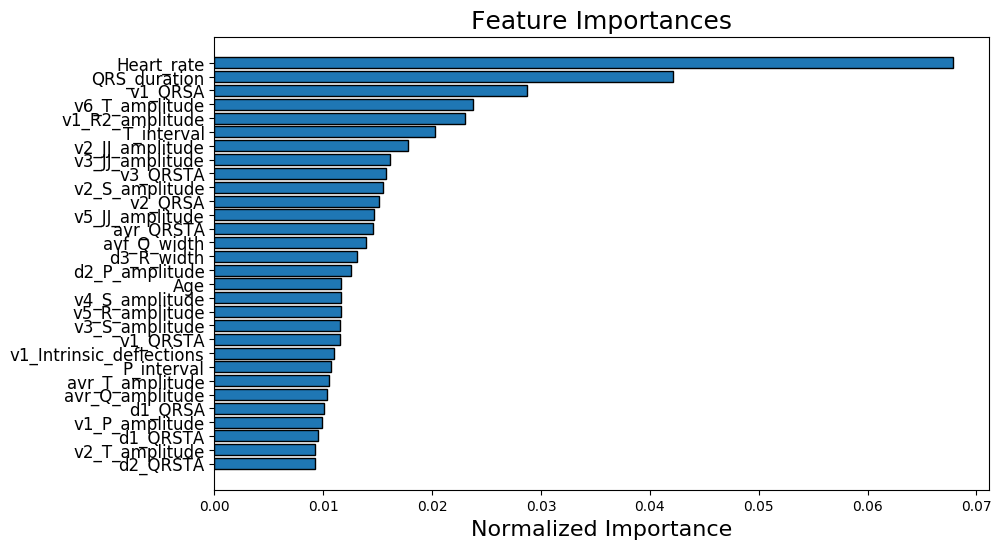

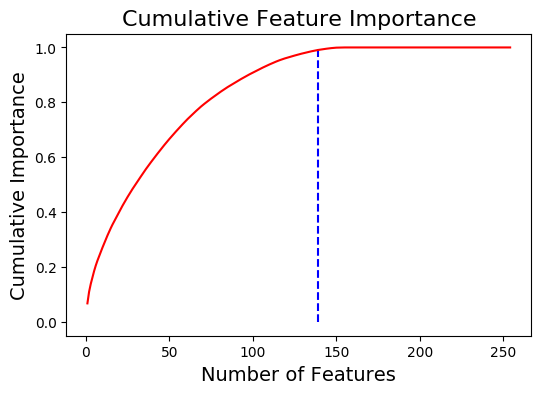

139 features required for 0.99 of cumulative importance


In [79]:
# plot the feature importances
fs.plot_feature_importances(threshold = 0.99, plot_n = 30)

In [35]:
data1.drop(zero_importance_features,axis=1,inplace=True)
data1.shape

(452, 155)

## Low Importance

In [36]:
fs.identify_low_importance(cumulative_importance = 0.99)

138 features required for cumulative importance of 0.99 after one hot encoding.
116 features do not contribute to cumulative importance of 0.99.



In [37]:
low_importance_features = fs.ops['low_importance']
low_importance_features

['v2_R_width',
 'd1_Q_amplitude',
 'v5_Q_amplitude',
 'd2_Intrinsic_deflections',
 'd2_Q_amplitude',
 'v3_Q_amplitude',
 'v1_R_width',
 'd3_S_amplitude',
 'v6_Q_width',
 'avl_Q_width',
 'd3_S_width',
 'd1_Q_width',
 'avr_S_amplitude',
 'v6_Q_amplitude',
 'v1_Q_amplitude',
 'avr_S_width',
 'v2_Exist_diphasic_P',
 'v2_Exist_diphasic_T',
 'v3_Exist_ragged_T',
 'v4_R2_width',
 'v4_S2_width',
 'v3_Exist_diphasic_P',
 'v4_Exist_ragged_R',
 'v4_Exist_diphasic_R',
 'v4_Exist_ragged_T',
 'v4_Exist_diphasic_T',
 'v3_Exist_ragged_P',
 'v5_R2_width',
 'v5_Exist_diphasic_R',
 'v5_Exist_diphasic_P',
 'v5_Exist_diphasic_T',
 'v3_Exist_diphasic_R',
 'v6_R2_width',
 'v6_Exist_ragged_R',
 'v6_Exist_diphasic_R',
 'v6_Exist_ragged_P',
 'v6_Exist_diphasic_T',
 'avf_Exist_diphasic_T',
 'd2_R2_amplitude',
 'v2_Q_width',
 'v1_S2_width',
 'd2_Exist_diphasic_P',
 'd2_Exist_ragged_P',
 'v2_Exist_ragged_P',
 'd2_Exist_diphasic_R',
 'v2_Exist_diphasic_R',
 'd2_Exist_ragged_R',
 'v2_Exist_ragged_R',
 'd3_R2_amplitu

In [38]:
data1.shape

(452, 155)

In [39]:
for index in range(len(low_importance_features)):
    if(low_importance_features[index] in data1.columns):
        data1.drop(low_importance_features[index],axis=1,inplace=True)
        print('tr')
    else:
        print('false')

tr
tr
tr
tr
tr
tr
tr
tr
tr
tr
tr
tr
tr
tr
tr
tr
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
tr
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false


In [40]:
data1.shape

(452, 138)

In [41]:
data1.head()

,Age,Sex,Height,Weight,QRS_duration,PR_interval,QT_interval,T_interval,P_interval,QRS_angle,...,v5_T_amplitude,v5_QRSA,v5_QRSTA,v6_JJ_amplitude,v6_R_amplitude,v6_S_amplitude,v6_P_amplitude,v6_T_amplitude,v6_QRSA,v6_QRSTA
0,75,0,190,80,91,193,371,174,121,-16,...,3.9,25.5,62.9,-0.3,9.0,-0.9,0.9,2.9,23.3,49.4
1,56,1,165,64,81,174,401,149,39,25,...,2.6,21.6,43.4,-0.5,8.5,0.0,0.2,2.1,20.4,38.8
2,54,0,172,95,138,163,386,185,102,96,...,3.4,11.5,48.2,0.9,9.5,-2.4,0.3,3.4,12.3,49.0
3,55,0,175,94,100,202,380,179,143,28,...,3.0,36.8,68.0,0.1,12.2,-2.2,0.4,2.6,34.6,61.6
4,75,0,190,80,88,181,360,177,103,-16,...,2.9,21.7,48.9,-0.4,13.1,-3.6,-0.1,3.9,25.4,62.8


In [42]:
X_train, X_test, y_train, y_test = train_test_split(data1, denemetarg, test_size=0.2,random_state=109) # 80% training and 20% test

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25,random_state=109) # 70% training and 30% test

In [44]:
X_train.shape,y_train.shape, X_valid.shape, y_valid.shape, X_test.shape,y_test.shape

((270, 138), (270,), (91, 138), (91,), (91, 138), (91,))

In [45]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

In [46]:

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.7582417582417582
              precision    recall  f1-score   support

           0       0.73      0.85      0.78        47
           1       0.81      0.66      0.73        44

   micro avg       0.76      0.76      0.76        91
   macro avg       0.77      0.76      0.75        91
weighted avg       0.77      0.76      0.76        91

[[40  7]
 [15 29]]


In [47]:
y_pred2=gnb.predict(X_valid)

In [48]:
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred2))
print(metrics.classification_report(y_valid, y_pred2))
print(metrics.confusion_matrix(y_valid, y_pred2))

Accuracy: 0.7472527472527473
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        51
           1       0.76      0.62      0.68        40

   micro avg       0.75      0.75      0.75        91
   macro avg       0.75      0.73      0.74        91
weighted avg       0.75      0.75      0.74        91

[[43  8]
 [15 25]]


## Bernoulli NB

In [49]:
bnb=BernoulliNB()
bnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = bnb.predict(X_test)

In [50]:

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.7692307692307693
              precision    recall  f1-score   support

           0       0.72      0.89      0.80        47
           1       0.85      0.64      0.73        44

   micro avg       0.77      0.77      0.77        91
   macro avg       0.79      0.76      0.76        91
weighted avg       0.78      0.77      0.76        91

[[42  5]
 [16 28]]


In [51]:
y_pred2=bnb.predict(X_valid)

In [52]:
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred2))
print(metrics.classification_report(y_valid, y_pred2))
print(metrics.confusion_matrix(y_valid, y_pred2))

Accuracy: 0.6923076923076923
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        51
           1       0.68      0.57      0.62        40

   micro avg       0.69      0.69      0.69        91
   macro avg       0.69      0.68      0.68        91
weighted avg       0.69      0.69      0.69        91

[[40 11]
 [17 23]]


## Standard Scaler

In [133]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(data1)

/home/kaya/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [122]:
X_scaled = scaler.transform(data1)

/home/kaya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [123]:
X_scaled

array([[ 1.73443926, -1.1075202 ,  0.64132669, ...,  1.17773685,
         0.29460309,  1.07867028],
       [ 0.57931213,  0.90291807, -0.03199781, ...,  0.61612582,
         0.0796127 ,  0.50487408],
       [ 0.4577198 , -1.1075202 ,  0.15653305, ...,  1.52874375,
        -0.52087767,  1.0570176 ],
       ...,
       [-0.63661117, -1.1075202 , -0.00506483, ..., -0.15608935,
        -4.7094834 , -3.3926096 ],
       [-0.87979583,  0.90291807, -0.30132761, ...,  0.82672996,
         0.42063193,  0.92710147],
       [ 1.91682776,  0.90291807, -0.16666271, ...,  0.26511892,
         0.14633386,  0.18008377]])

In [124]:
X_sctrain, X_sctest, y_sctrain, y_sctest = train_test_split(X_scaled, denemetarg, test_size=0.2,random_state=109) # 80% training and 20% test

In [125]:
X_sctrain, X_scvalid, y_sctrain, y_scvalid = train_test_split(X_sctrain, y_sctrain, test_size=0.25,random_state=109) # 70% training and 30% test

In [127]:
#Train the model using the training sets
gnb.fit(X_sctrain, y_sctrain)

#Predict the response for test dataset
y_scpred = gnb.predict(X_sctest)

In [128]:

print("Accuracy:",metrics.accuracy_score(y_sctest, y_scpred))
print(metrics.classification_report(y_sctest, y_scpred))
print(metrics.confusion_matrix(y_sctest, y_scpred))

Accuracy: 0.7582417582417582
              precision    recall  f1-score   support

           0       0.73      0.85      0.78        47
           1       0.81      0.66      0.73        44

   micro avg       0.76      0.76      0.76        91
   macro avg       0.77      0.76      0.75        91
weighted avg       0.77      0.76      0.76        91

[[40  7]
 [15 29]]


In [130]:
y_scpredvalid = gnb.predict(X_scvalid)

In [131]:

print("Accuracy:",metrics.accuracy_score(y_scvalid, y_scpredvalid))
print(metrics.classification_report(y_scvalid, y_scpredvalid))
print(metrics.confusion_matrix(y_scvalid, y_scpredvalid))

Accuracy: 0.7472527472527473
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        51
           1       0.76      0.62      0.68        40

   micro avg       0.75      0.75      0.75        91
   macro avg       0.75      0.73      0.74        91
weighted avg       0.75      0.75      0.74        91

[[43  8]
 [15 25]]


In [57]:
#fs.feature_importances

In [161]:
gereklifeaturelar=data1.iloc[:,0:4]
otherdata=data1.iloc[:,4:]
gereklifeaturelar.shape,otherdata.shape

((452, 4), (452, 134))

In [451]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=56)
m=pca.fit(otherdata.T)
scaler = preprocessing.StandardScaler().fit(gereklifeaturelar)
gerekliscaled = scaler.transform(gereklifeaturelar)
#data2=np.concatenate(gereklifeaturelar,m.components_)

digersc=m.components_.T
gerekliscaled.shape,digersc.shape
data2=np.concatenate((gerekliscaled,digersc),axis=1)

/home/kaya/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/kaya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  import sys


In [452]:
data2

array([[ 1.73443926e+00, -1.10752020e+00,  6.41326695e-01, ...,
        -2.21900802e-02,  9.54008109e-03, -2.66057507e-02],
       [ 5.79312129e-01,  9.02918072e-01, -3.19978106e-02, ...,
         3.01795585e-02,  4.46520247e-03,  5.26519126e-02],
       [ 4.57719799e-01, -1.10752020e+00,  1.56533051e-01, ...,
        -2.32563644e-03,  5.86994305e-02, -8.45948511e-02],
       ...,
       [-6.36611170e-01, -1.10752020e+00, -5.06483035e-03, ...,
         7.42753776e-02, -5.56119442e-02, -2.30876236e-01],
       [-8.79795829e-01,  9.02918072e-01, -3.01327613e-01, ...,
         8.61304364e-03, -2.37780242e-02,  5.46564847e-04],
       [ 1.91682776e+00,  9.02918072e-01, -1.66662712e-01, ...,
         2.68688723e-02, -6.46741881e-02,  4.56186095e-02]])

In [453]:
X_train1scaledcomb, X_test1scaledcomb, y_train1scaledcomb, y_test1scaledcomb=train_test_split(data2, denemetarg, test_size=0.2, random_state=1)

X_train1scaledcomb, X_val1scaledcomb, y_train1scaledcomb, y_val1scaledcomb= train_test_split(X_train1scaledcomb, y_train1scaledcomb, test_size=0.25, random_state=1)

In [454]:
gnb.fit(X_train1scaledcomb, y_train1scaledcomb)

#Predict the response for test dataset
y_predtestscaledcomb = gnb.predict(X_test1scaledcomb)
y_predvalscaledcomb = gnb.predict(X_val1scaledcomb)

Accuracy: 0.8131868131868132
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        52
           1       0.89      0.64      0.75        39

   micro avg       0.81      0.81      0.81        91
   macro avg       0.84      0.79      0.80        91
weighted avg       0.83      0.81      0.81        91

[[49  3]
 [14 25]]
Accuracy: 0.7582417582417582
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        56
           1       0.68      0.71      0.69        35

   micro avg       0.76      0.76      0.76        91
   macro avg       0.75      0.75      0.75        91
weighted avg       0.76      0.76      0.76        91

[[44 12]
 [10 25]]


/home/kaya/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/kaya/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/kaya/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/home/kaya/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/home/kaya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DataConversionWarning: Data with input dtype 


Standardize edilmemiş veriler, test sonucu, PCA feature =56
71.43%

              precision    recall  f1-score   support

           0       0.68      0.83      0.75        47
           1       0.76      0.59      0.67        44

   micro avg       0.71      0.71      0.71        91
   macro avg       0.72      0.71      0.71        91
weighted avg       0.72      0.71      0.71        91

[[39  8]
 [18 26]]

PStandardize edilmemiş veriler, validation sonucu, PCA feature =56
74.73%

              precision    recall  f1-score   support

           0       0.74      0.84      0.79        51
           1       0.76      0.62      0.68        40

   micro avg       0.75      0.75      0.75        91
   macro avg       0.75      0.73      0.74        91
weighted avg       0.75      0.75      0.74        91

[[43  8]
 [15 25]]

Standardize edilmiş veriler, test sonucu, PCA feature =56
73.63%

              precision    recall  f1-score   support

           0       0.69      0.87      0.

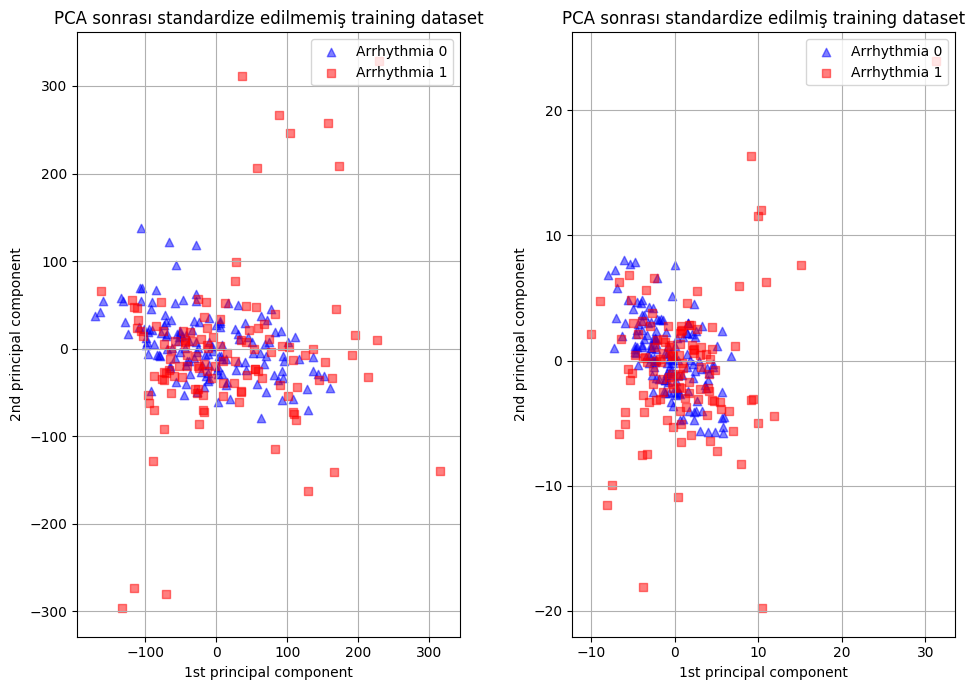

In [495]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline

FIG_SIZE = (10, 7)
feature=56
# Fit to data and predict using pipelined GNB and PCA.
unscaled_clf = make_pipeline(PCA(n_components=feature), GaussianNB())
unscaled_clf.fit(X_train, y_train)
pred_test = unscaled_clf.predict(X_test)
pred_valid = unscaled_clf.predict(X_valid)

# Fit to data and predict using pipelined scaling, GNB and PCA.
std_clf = make_pipeline(StandardScaler(), PCA(n_components=feature), GaussianNB())
std_clf.fit(X_train, y_train)
pred_test_std = std_clf.predict(X_test)
pred_valid_std = std_clf.predict(X_valid)

# Show prediction accuracies in scaled and unscaled data.
print('\nStandardize edilmemiş veriler, test sonucu, PCA feature =56')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))
print(metrics.classification_report(y_test, pred_test))
print(metrics.confusion_matrix(y_test, pred_test))
print('\nPStandardize edilmemiş veriler, validation sonucu, PCA feature =56')
print('{:.2%}\n'.format(metrics.accuracy_score(y_valid, pred_valid)))
print(metrics.classification_report(y_valid, pred_valid))
print(metrics.confusion_matrix(y_valid, pred_valid))
print('\nStandardize edilmiş veriler, test sonucu, PCA feature =56')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_std)))
print(metrics.classification_report(y_test, pred_test_std))
print(metrics.confusion_matrix(y_test, pred_test_std))
print('\nStandardize edilmiş veriler, validation sonucu, PCA feature =56')
print('{:.2%}\n'.format(metrics.accuracy_score(y_valid, pred_valid_std)))
print(metrics.classification_report(y_valid, pred_valid_std))
print(metrics.confusion_matrix(y_valid, pred_valid_std))
      
# Model Accuracy, how often is the classifier correct?
print('\nİlk dört feature sabit olmak üzere, standardize edilmiş veriler, test sonucu, PCA feature =56')
print("Accuracy:",metrics.accuracy_score(y_test1scaledcomb, y_predtestscaledcomb))
print(metrics.classification_report(y_test1scaledcomb, y_predtestscaledcomb))
print(metrics.confusion_matrix(y_test1scaledcomb, y_predtestscaledcomb))

print('\nİlk dört feature sabit olmak üzere, standardize edilmiş veriler, validation sonucu, PCA feature =56')
print("Accuracy:",metrics.accuracy_score(y_val1scaledcomb, y_predvalscaledcomb))
print(metrics.classification_report(y_val1scaledcomb, y_predvalscaledcomb))
print(metrics.confusion_matrix(y_val1scaledcomb, y_predvalscaledcomb))

# Use PCA without and with scale on X_train data for visualization.
X_train_transformed = pca.transform(X_train)
scaler = std_clf.named_steps['standardscaler']
X_train_std_transformed = pca_std.transform(scaler.transform(X_train))

# visualize standardized vs. untouched dataset with PCA performed
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=FIG_SIZE)


for l, c, m in zip(range(0, 2), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax1.scatter(X_train_transformed[y_train == l, 0],
                X_train_transformed[y_train == l, 1],
                color=c,
                label='Arrhythmia %s' % l,
                alpha=0.5,
                marker=m
                )

for l, c, m in zip(range(0, 2), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax2.scatter(X_train_std_transformed[y_train == l, 0],
                X_train_std_transformed[y_train == l, 1],
                color=c,
                label='Arrhythmia %s' % l,
                alpha=0.5,
                marker=m
                )

ax1.set_title('PCA sonrası standardize edilmemiş training dataset')
ax2.set_title('PCA sonrası standardize edilmiş training dataset')

for ax in (ax1, ax2):
    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()

plt.show()